In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set file path
file_path = r"E:\UNU-MERIT\Thesis\ClimateMobility\climate-migration-model\data\raw\international_migration_flow.csv"
df_raw = pd.read_csv(file_path)
print(df_raw.head())

  country_from country_to migration_month  num_migrants
0           AD         AE         2019-01            12
1           AD         AE         2019-02             2
2           AD         AE         2019-03             1
3           AD         AE         2019-04             7
4           AD         AE         2019-05             0


查看原本数据的缺失情况

In [ ]:
# 读取国家代码映射表
code_map = pd.read_csv('../data/raw/countries_codes_263.csv')

# 匹配 origin 国家名和ISO3
df_raw_check = df_raw.merge(code_map[['Alpha-2 code', 'Country', 'Alpha-3 code']], left_on='country_from', right_on='Alpha-2 code', how='left')
df_raw_check = df_raw_check.rename(columns={'Country': 'origin_name', 'Alpha-3 code': 'origin_iso3'})

# 匹配 destination 国家名和ISO3
df_raw_check = df_raw_check.merge(code_map[['Alpha-2 code', 'Country', 'Alpha-3 code']], left_on='country_to', right_on='Alpha-2 code', how='left', suffixes=('', '_dest'))
df_raw_check = df_raw_check.rename(columns={'Country_dest': 'destination_name', 'Alpha-3 code_dest': 'destination_iso3'})

# 找出有缺失值的行
missing_rows = df_raw_check[df_raw_check['country_from'].isnull() | df_raw_check['country_to'].isnull()]

# 输出前几行查看
print(missing_rows.head())

# 保存为单独的表
missing_rows.to_csv(r"E:\UNU-MERIT\Thesis\ClimateMobility\climate-migration-model\data\processed\migration_missing_country_with_names.csv", index=False)
print("已保存有缺失国家代码的迁移流记录（含国家名和ISO3）到 migration_missing_country_with_names.csv")

     country_from country_to migration_month  num_migrants Alpha-2 code  \
5856           AD        NaN         2019-01             0           AD   
5857           AD        NaN         2019-02             4           AD   
5858           AD        NaN         2019-03             0           AD   
5859           AD        NaN         2019-04             0           AD   
5860           AD        NaN         2019-05            11           AD   

     origin_name origin_iso3 Alpha-2 code_dest  Country Alpha-3 code  
5856     Andorra         AND               NaN  Namibia          NAM  
5857     Andorra         AND               NaN  Namibia          NAM  
5858     Andorra         AND               NaN  Namibia          NAM  
5859     Andorra         AND               NaN  Namibia          NAM  
5860     Andorra         AND               NaN  Namibia          NAM  
已保存有缺失国家代码的迁移流记录（含国家名和ISO3）到 migration_missing_country_with_names.csv


In [8]:
# === 1. Preliminary check of data ===
print("data shape:", df_raw.shape)

print("data type:\n", df_raw.dtypes)

print("missing value:\n", df_raw.isnull().sum())
missing = df_raw.isnull().mean().sort_values(ascending=False) # check missing ratio
print("missing ratio:\n",missing)
df = df_raw.dropna(subset=['country_from', 'country_to']).copy() # Delete records with missing values

print("Basic statistics on migration:\n", df['num_migrants'].describe())


data shape: (1563154, 4)
data type:
 country_from       object
country_to         object
migration_month    object
num_migrants        int64
dtype: object
missing value:
 country_from       8640
country_to         8640
migration_month       0
num_migrants          0
dtype: int64
missing ratio:
 country_from       0.005527
country_to         0.005527
migration_month    0.000000
num_migrants       0.000000
dtype: float64
Basic statistics on migration:
 count    1.545874e+06
mean     7.678771e+01
std      9.029347e+02
min      0.000000e+00
25%      0.000000e+00
50%      3.000000e+00
75%      1.200000e+01
max      1.639370e+05
Name: num_migrants, dtype: float64


未匹配上的 origin 国家代码: []
未匹配上的 destination 国家代码: []
missing value:
 origin              0
destination         0
migration_month     0
flow                0
year                0
month               0
log_flow            0
origin_iso3         0
destination_iso3    0
dtype: int64


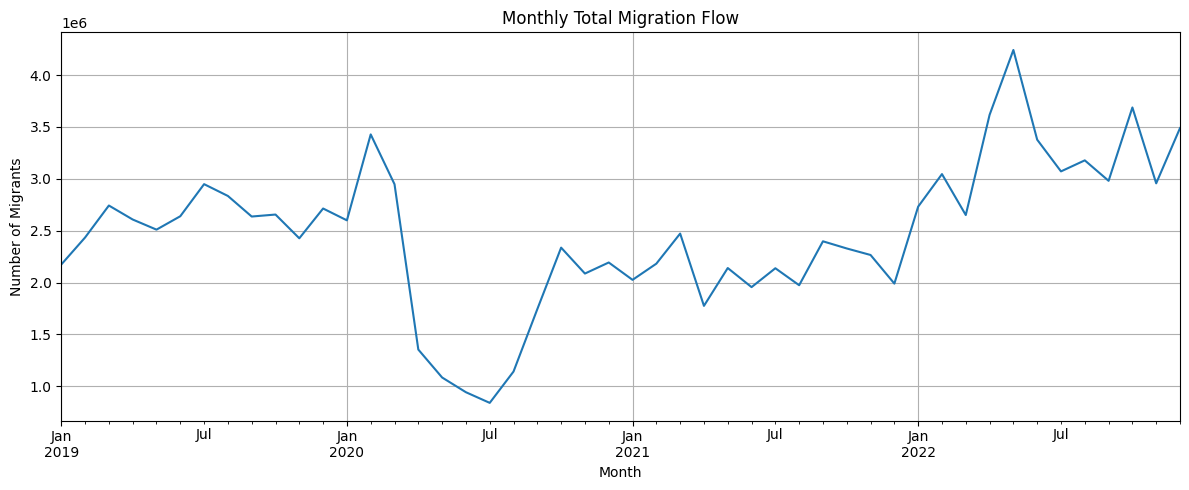

In [ ]:
# === 2. Convert date and extract year, month ===
df['migration_month'] = pd.to_datetime(df['migration_month'])
df['year'] = df['migration_month'].dt.year
df['month'] = df['migration_month'].dt.month

# === 3. Rename columns for clarity ===
df.rename(columns={
    'country_from': 'origin',
    'country_to': 'destination',
    'num_migrants': 'flow'
}, inplace=True)

# === 4. Create log-transformed migration flow to be used as dependent variable in regression===
df['log_flow'] = np.log1p(df['flow'])

# === 5. Map origin and destination countries to ISO3 codes ===
iso2_to_iso3 = dict(zip(code_map['Alpha-2 code'], code_map['Alpha-3 code']))

# 替换 origin 和 destination 字段为 iso3
df['origin_iso3'] = df['origin'].map(iso2_to_iso3)
df['destination_iso3'] = df['destination'].map(iso2_to_iso3)

# 检查未匹配上的国家代码
print("未匹配上的 origin 国家代码:", df[df['origin_iso3'].isnull()]['origin'].unique())
print("未匹配上的 destination 国家代码:", df[df['destination_iso3'].isnull()]['destination'].unique())


print("missing value:\n", df.isnull().sum())
# === 6. Save cleaned migration data for later merging with other datasets ===
output_path = r"E:\UNU-MERIT\Thesis\ClimateMobility\climate-migration-model\data\processed\migration_flow_test.csv"
df.to_csv(output_path, index=False)

# === 7. Trends in total monthly global migration ===
monthly_total = df.groupby('migration_month')['flow'].sum()
plt.figure(figsize=(12, 5))
monthly_total.plot()
plt.title("Monthly Total Migration Flow")
plt.xlabel("Month")
plt.ylabel("Number of Migrants")
plt.grid(True)
plt.tight_layout()
plt.savefig("plot_monthly_total_flow.png")


Top 10 migration routes:
 origin_iso3  destination_iso3
MEX          USA                 2266749
VEN          COL                 1809264
IND          ARE                 1668749
SAU          IND                 1590880
MYS          IDN                 1219910
BGD          SAU                 1215609
SAU          PAK                 1139580
ARE          IND                 1079132
IND          SAU                 1030282
SAU          PHL                 1005698
Name: flow, dtype: int64

Top 10 origin countries:
 origin_iso3
IND    8916761
SAU    7295844
USA    3869882
VEN    3791224
PHL    3321684
BGD    3202960
MYS    3102343
UKR    3049808
ARE    2956837
PAK    2925127
Name: flow, dtype: int64

Top 10 destination countries:
 destination_iso3
USA    10248130
SAU     6445863
IND     6254349
ARE     5187573
GBR     3694022
DEU     3258035
PHL     3146512
CAN     2747780
ESP     2670838
BGD     2596922
Name: flow, dtype: int64


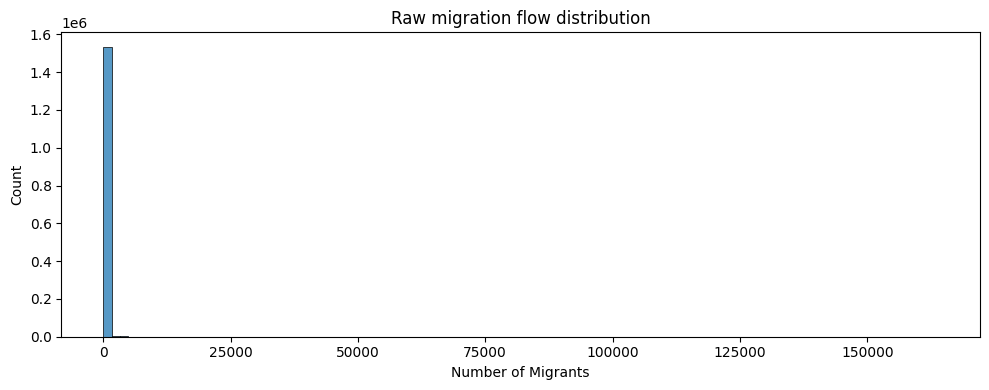

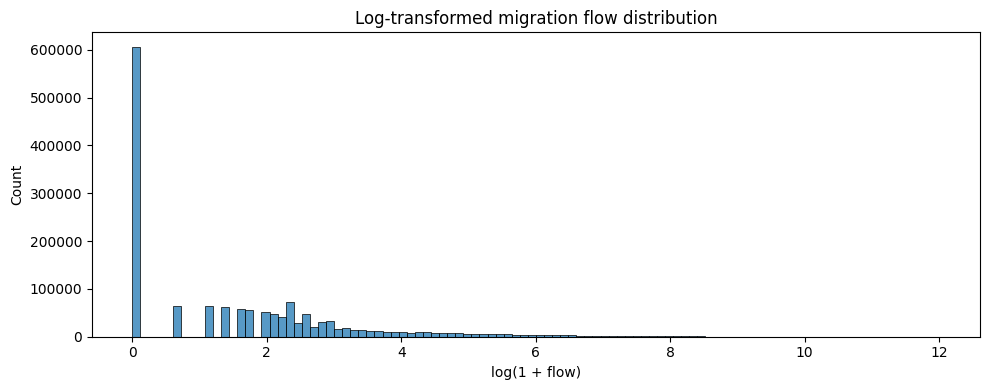

In [12]:
# 8. （可选）迁移路线和分布分析
top_routes = df.groupby(['origin_iso3', 'destination_iso3'])['flow'].sum().sort_values(ascending=False).head(10)
print("\nTop 10 migration routes:\n", top_routes)
top_origins = df.groupby('origin_iso3')['flow'].sum().sort_values(ascending=False).head(10)
top_destinations = df.groupby('destination_iso3')['flow'].sum().sort_values(ascending=False).head(10)
print("\nTop 10 origin countries:\n", top_origins)
print("\nTop 10 destination countries:\n", top_destinations)
plt.figure(figsize=(10, 4))
sns.histplot(df['flow'], bins=100)
plt.title("Raw migration flow distribution")
plt.xlabel("Number of Migrants")
plt.tight_layout()
# plt.savefig(r"E:\UNU-MERIT\Thesis\ClimateMobility\climate-migration-model\plot_raw_flow_distribution.png")
plt.figure(figsize=(10, 4))
sns.histplot(df['log_flow'], bins=100)
plt.title("Log-transformed migration flow distribution")
plt.xlabel("log(1 + flow)")
plt.tight_layout()
# plt.savefig(r"E:\UNU-MERIT\Thesis\ClimateMobility\climate-migration-model\plot_log_flow_distribution.png")